# Hawaii Climate Analysis

Analyze the climate in Hawaii with Pandas and SQLAlchemy.

In [2]:
%matplotlib inline

#dependencies
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
# set up SQLite DB
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# view all classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

---
## Exploratory Climate Analysis
* Design a query to retrieve the last 12 months of precipitation data.
* Select only the date and precipitation values.
* Load the query results into a Pandas DataFrame.
* Plot the results in a line graph.
* Use Pandas to print the summary statistics for the precipitation data.

In [8]:
# Retrieve the last 12 months of precipitation data by first setting up the date range
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [9]:
# Calculate the date 1 year ago from recent_date
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23


In [10]:
# Query precipitation for the last year & sort by date
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date>one_year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip) 
precip_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


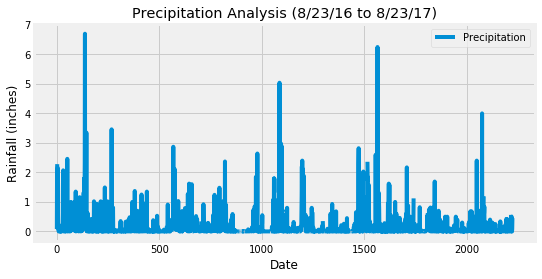

In [72]:
# Plot the data
ax = precip_df.plot(figsize=(8,4))
ax.set_title("Precipitation Analysis (8/23/16 to 8/23/17)")
ax.set_ylabel("Rainfall (inches)")
ax.set_xlabel("Date")
plt.legend(["Precipitation"])
plt.savefig("Images/precip_analysis.png")
plt.show()

In [12]:
# calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


---
## Station Analysis
* Design a query to calculate the total number of stations.
* Design a query to find the most active stations.
* List the stations and observation counts in descending order
* Which station has the highest number of observations?
* Design a query to retrieve the last 12 months of temperature observation data (tobs).
* Filter by the station with the highest number of observations.
* Plot the results as a histogram with bins=12.

In [13]:
# How many stations are there?
stations = session.query(Station.station).count()
print(f"There are {stations} stations.")

There are 9 stations.


In [14]:
# What are the most active stations? List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
            group_by(Measurement.station).\
            order_by('count DESC').all()
most_active

C:\Users\carte\AppData\Local\conda\conda\envs\SarahClassDev\lib\site-packages\sqlalchemy\sql\compiler.py:763: SAWarning: Can't resolve label reference 'count DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element),


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# What is the most active station?
busiest = most_active[0][0]    
print(f"The busiest Station was {busiest} with {most_active[0][1]} weather observations.")

The busiest Station was USC00519281 with 2772 weather observations.


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*temp).filter(Measurement.station==busiest).all()

[(54.0, 85.0, 71.66378066378067)]

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()
temp_df = pd.DataFrame(temperature)
temp_df.head()

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


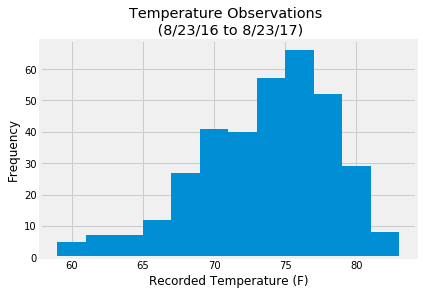

In [71]:
plt.hist(temp_df["tobs"],12)
plt.ylabel("Frequency")
plt.xlabel("Recorded Temperature (F)")
plt.title("Temperature Observations \n (8/23/16 to 8/23/17)")
plt.show
plt.savefig("Images/tobs.png")

---
## Temperature Analysis
* Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.

* Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

* Plot the min, avg, and max temperature from your previous query as a bar chart.

* Use the average temperature as the bar height.

* Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [19]:
# This function called `calc_temps` accepts start and end dates in the format '%Y-%m-%d' 
# and returns the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


### Analyze temps for your trip
Use the function `calc_temps` from above to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.

Note: I realized the dataset is older than one year prior from my "planned" trip date, so I will analyze the data from two years back.

In [20]:
# Define my trip dates (going to Hawaii right after I complete this bootcamp)
trip_start = dt.date(2019, 5, 20)
trip_end = dt.date(2019, 5, 28)
# compare to 2-years-ago-weather at this time of year
comparison = dt.timedelta(days=730)
last_year_avgs = (calc_temps((trip_start-comparison), (trip_end-comparison)))
print(last_year_avgs)

[(69.0, 75.15384615384616, 87.0)]


### Plot the results from your previous query.
* Use "Trip Avg Temp" as your Title
* Use the average temperature for the y value
* Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

Note: The assignment asked for a bar chart but I find a box & whisker more effective, so I did that.

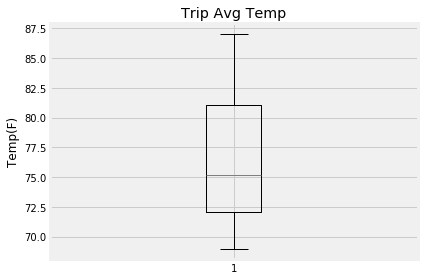

In [73]:
# charting
plt.boxplot(last_year_avgs)
plt.ylabel("Temp(F)")
plt.title("Trip Avg Temp")
plt.tight_layout()
plt.savefig("Images/avg_temp_boxplot.png")
plt.show()

---
## Analyze the Rainfall for Your Trip
Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [100]:
# store comparison dates from 2 years prior to my trip
comparison_start = (trip_start-comparison)
comparison_end = (trip_end-comparison)

In [115]:
# query and subquery to get data from both sql tables
q = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,                       
                  Station.latitude,
                  Station.longitude,
                  Station.elevation)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= comparison_start)\
.filter(Measurement.date <= comparison_end)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

# read the results
print (f"Historical Rainfall Per Weather Station \n\
My Trip Dates: {trip_start} to {trip_end}\n\
Data Search Dates: {comparison_start} to {comparison_end}")
print("-----------------------------------------------------------")
print("-----------------------------------------------------------")

for row in q:
    #---format---
    rain="{0:.2f}".format(row[1])
    elev="{0:.2f}".format(row[3])
    lat="{0:.2f}".format(row[4])
    long="{0:.2f}".format(row[5])
    #---print---
    print(f"Station: {row[0]}\n\
    Rainfall:{rain}\n\
    Location: {row[2]}\n\
    Elevation:{elev}\n\
    Latitude: {lat}\n\
    Longitude: {long}")
    print("-----------------------------------------------------------")


Historical Rainfall Per Weather Station 
My Trip Dates: 2019-05-20 to 2019-05-28
Data Search Dates: 2017-05-20 to 2017-05-28
-----------------------------------------------------------
-----------------------------------------------------------
Station: USC00516128
    Rainfall:4.29
    Location: MANOA LYON ARBO 785.2, HI US
    Elevation:21.33
    Latitude: -157.80
    Longitude: 152.40
-----------------------------------------------------------
Station: USC00513117
    Rainfall:1.28
    Location: KANEOHE 838.1, HI US
    Elevation:21.42
    Latitude: -157.80
    Longitude: 14.60
-----------------------------------------------------------
Station: USC00519523
    Rainfall:1.16
    Location: WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:21.34
    Latitude: -157.71
    Longitude: 19.50
-----------------------------------------------------------
Station: USC00519281
    Rainfall:0.73
    Location: WAIHEE 837.5, HI US
    Elevation:21.45
    Latitude: -157.85
    Longitude: 32.90
-----

## Optional Challenge Assignment

The following are optional challenge queries. These are recommended to attempt, but not required for the homework.

* Calculate the rainfall per weather station using the previous year's matching dates.
* Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.

* Create a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic tobs that match that date string.

* Create a list of dates for your trip in the format %m-%d. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

* Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

* Use Pandas to plot an area plot (stacked=False) for the daily normals.

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# print the trip variables of arrive and leave date for comparison year (2 years ago)
print(comparison_start)
print(comparison_end)

2017-05-20
2017-05-28


In [29]:
# query the rain data from comparison year
vacation_data = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= comparison_start).\
    filter(Measurement.date <= comparison_end).\
    order_by(Measurement.station).all()

In [30]:
# load the query results into a dataframe with station as index
vacation_df=pd.DataFrame(vacation_data)

rain_per_station = pd.pivot_table(vacation_df,index=['station'],values=['prcp'], aggfunc=sum)
rain_per_station

,prcp
station,
USC00513117,1.28
USC00514830,0.31
USC00516128,4.29
USC00519281,0.73
USC00519397,0.39
USC00519523,1.16


In [57]:
# calculate the daily normals for your trip

# Set the start and end date of the trip
comparison_start
comparison_end

# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings
trip_dates= pd.date_range(comparison_start, comparison_end, freq='D')
trip_dates_dm = trip_dates.strftime("%m-%d")
trip_dates_dm

#make lists to store data
t_date = []
t_min = []
t_max = []
t_avg = []
# Loop through the list of %m-%d strings and calculate the normals for each date
for d in trip_dates_dm:
    t_date.append(d)
    t_min.append(daily_normals(d)[0][0])
    t_max.append(daily_normals(d)[0][1])
    t_avg.append(daily_normals(d)[0][2])

#make dict to store looped data
normals_dict = {"date": t_date,
               "tmin": t_min,
               "tmax": t_max,
               "tavg": t_avg}
normals_dict

{'date': ['05-20',
  '05-21',
  '05-22',
  '05-23',
  '05-24',
  '05-25',
  '05-26',
  '05-27',
  '05-28'],
 'tmin': [68.0, 64.0, 64.0, 68.0, 67.0, 68.0, 65.0, 65.0, 67.0],
 'tmax': [73.89655172413794,
  72.96428571428571,
  74.45614035087719,
  74.94827586206897,
  73.94827586206897,
  74.27586206896552,
  74.03636363636363,
  74.49090909090908,
  74.27777777777777],
 'tavg': [79.0, 80.0, 80.0, 87.0, 79.0, 79.0, 82.0, 80.0, 82.0]}

In [58]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals_dict)
normals_df = normals_df.set_index('date')
normals_df

,tmin,tmax,tavg
date,,,
05-20,68.0,73.896552,79.0
05-21,64.0,72.964286,80.0
05-22,64.0,74.456140,80.0
05-23,68.0,74.948276,87.0
05-24,67.0,73.948276,79.0
05-25,68.0,74.275862,79.0
05-26,65.0,74.036364,82.0
05-27,65.0,74.490909,80.0
05-28,67.0,74.277778,82.0


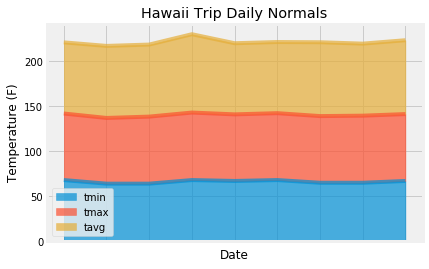

In [69]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked='false', alpha=.7)
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.title("Hawaii Trip Daily Normals")
plt.savefig("Images/daily_normals.png")

---
### YOU'VE REACHED THE END!!
---